In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.precision", 4)

In [48]:
# load data
data_dic = {}
directory = '/Users/jinghan/Documents/UCB/Winter/IAQF_Competition/prediction'

for subdir in os.listdir(directory):
    
    if subdir != '.DS_Store':

        data_dic[subdir] = {}
        
        for filename in os.listdir(os.path.join(directory, subdir, 'predict')):
            
            if filename.endswith('_d.pkl'):
                data_dic[subdir]['D'] = pd.read_pickle(os.path.join(directory, subdir, 'predict',filename))
            elif filename.endswith('_w.pkl'):
                data_dic[subdir]['W'] = pd.read_pickle(os.path.join(directory, subdir, 'predict',filename))
            elif filename.endswith('_M.pkl'):
                data_dic[subdir]['M'] = pd.read_pickle(os.path.join(directory, subdir, 'predict',filename))
            else:
                pass

In [49]:
def calculate_accuracy(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0] for c in df.columns]
    df = df.reset_index(drop=True)
    df['Date'] = pd.to_datetime(df['Date'],format="%Y-%m-%d")
    train_df = df[df.Date<'2017-01-01']
    test_df = df[df.Date>='2017-01-01']

    train_df['abs_error'] = np.abs(train_df['actual_spread'] - train_df['pred_spread'])
    train_df['sqrt_error'] = np.square(train_df['actual_spread'] - train_df['pred_spread'])
    test_df['abs_error'] = np.abs(test_df['actual_spread'] - test_df['pred_spread'])
    test_df['sqrt_error'] = np.square(test_df['actual_spread'] - test_df['pred_spread'])

    def cal_pred_m_mean(df):
        df = df.copy()
        df = df.merge(df.groupby('pair')['actual_spread'].mean(), how='left', left_on='pair', right_index=True)
        df = df.rename(columns={'actual_spread_x':'actual_spread', 'actual_spread_y':'actual_spread_mean'})
        return np.square(df['actual_spread'] - df['actual_spread_mean'])

    train_df['sq_pred_m_mean'] = cal_pred_m_mean(train_df)
    test_df['sq_pred_m_mean'] = cal_pred_m_mean(test_df)

    measures = {}
    measures['train MAE'] = [train_df['abs_error'].mean()]
    measures['train RMSE'] = [np.sqrt(train_df.groupby('pair').aggregate({'sqrt_error':'mean'})).mean().values[0]]
    r2_cal = train_df.groupby('pair').aggregate({'sqrt_error':'sum','sq_pred_m_mean':'sum'})
    measures['train R2'] = [(1 - r2_cal['sqrt_error']/r2_cal['sq_pred_m_mean']).mean()]
    measures['test MAE'] = [test_df['abs_error'].mean()]
    measures['test RMSE'] = [np.sqrt(test_df.groupby('pair').aggregate({'sqrt_error':'mean'})).mean().values[0]]
    measures['test R2'] = [np.sqrt(test_df.groupby('pair').aggregate({'sqrt_error':'mean'})).mean().values[0]]
    r2_cal = test_df.groupby('pair').aggregate({'sqrt_error':'sum','sq_pred_m_mean':'sum'})
    measures['test R2'] = [(1 - r2_cal['sqrt_error']/r2_cal['sq_pred_m_mean']).mean()]

    err_df = pd.concat([train_df[['Date','pair','abs_error','sqrt_error']],test_df[['Date','pair','abs_error','sqrt_error']]], axis=0)

    timeseries_measures = {}
    timeseries_measures['mae'] = err_df.pivot(index='Date',columns='pair',values='abs_error').rolling(10).mean(skipna=True).mean(axis=1, skipna=True)
    timeseries_measures['rmse'] = np.sqrt(err_df.pivot(index='Date',columns='pair',values='sqrt_error').rolling(10).mean(skipna=True).mean(axis=1, skipna=True))

    return measures, timeseries_measures

In [50]:
def summarize_accuracy(data_dic, period):

    results_table = pd.DataFrame()
    mae_df = pd.DataFrame()
    rmse_df = pd.DataFrame()

    for k in data_dic.keys():

        if k != 'copula':

            if period in data_dic[k]:

                df = data_dic[k][period].copy()
                measures, timeseries_measures = calculate_accuracy(df)

                out = pd.DataFrame(measures)
                out['Period'] = period
                out['Model'] = k
                results_table = pd.concat([results_table,out],axis=0)

                mae_df[k] = timeseries_measures['mae']
                rmse_df[k] = timeseries_measures['rmse']

    results_table = results_table.groupby(['Period','Model']).max()

    plt.rcParams['figure.figsize'] = [18, 8]
    fig,ax = plt.subplots(2,1)
    ax[0].plot(mae_df)
    ax[0].legend(mae_df.columns)
    ax[0].set_title("MAE over time (Period = {})".format(period))
    ax[1].plot(rmse_df)
    ax[1].legend(rmse_df.columns)
    ax[1].set_title("RMSE over time (Period = {})".format(period))
    plt.show()
    
    return results_table

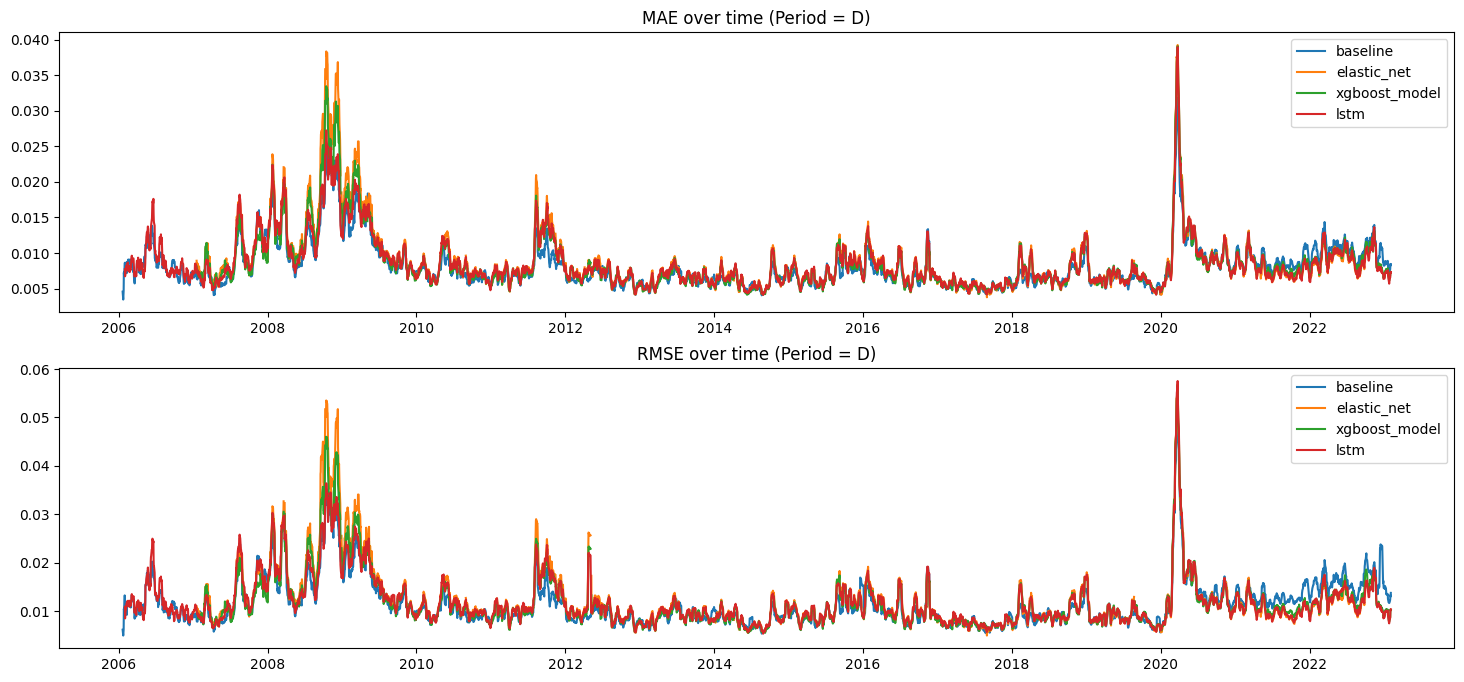

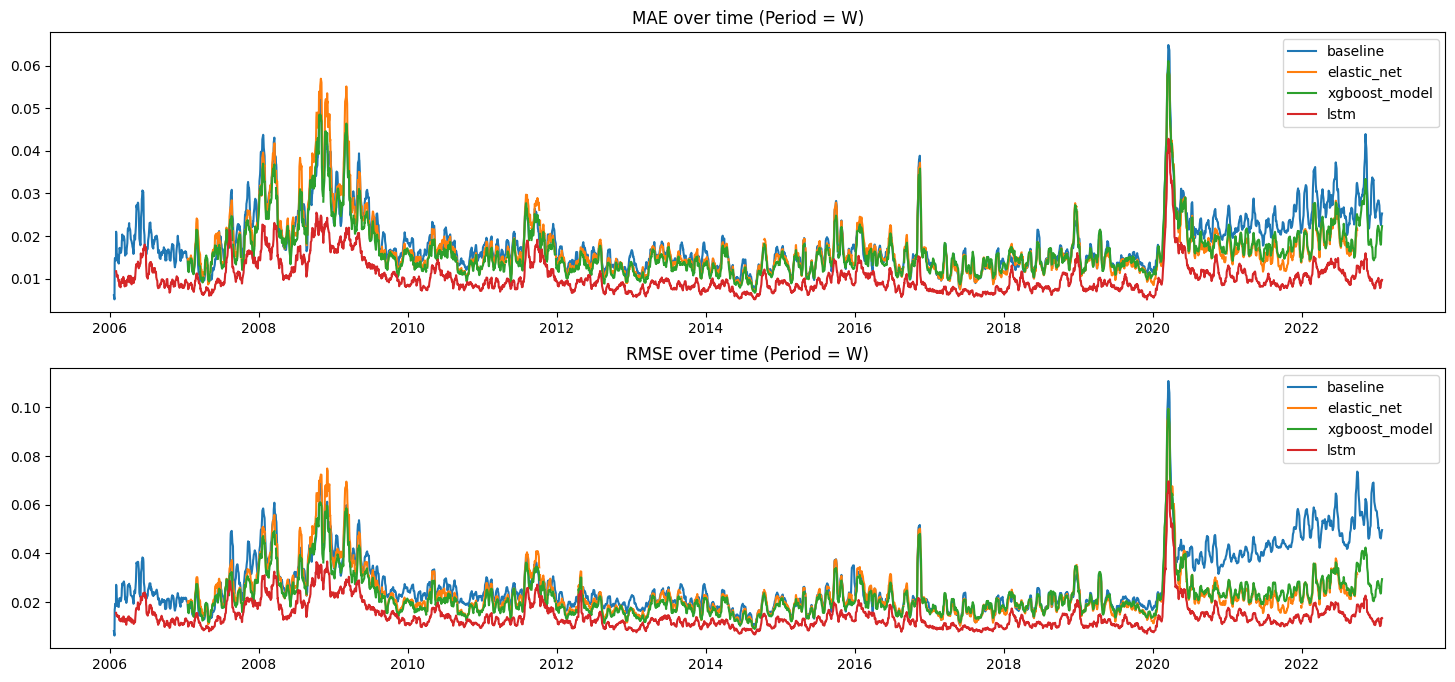

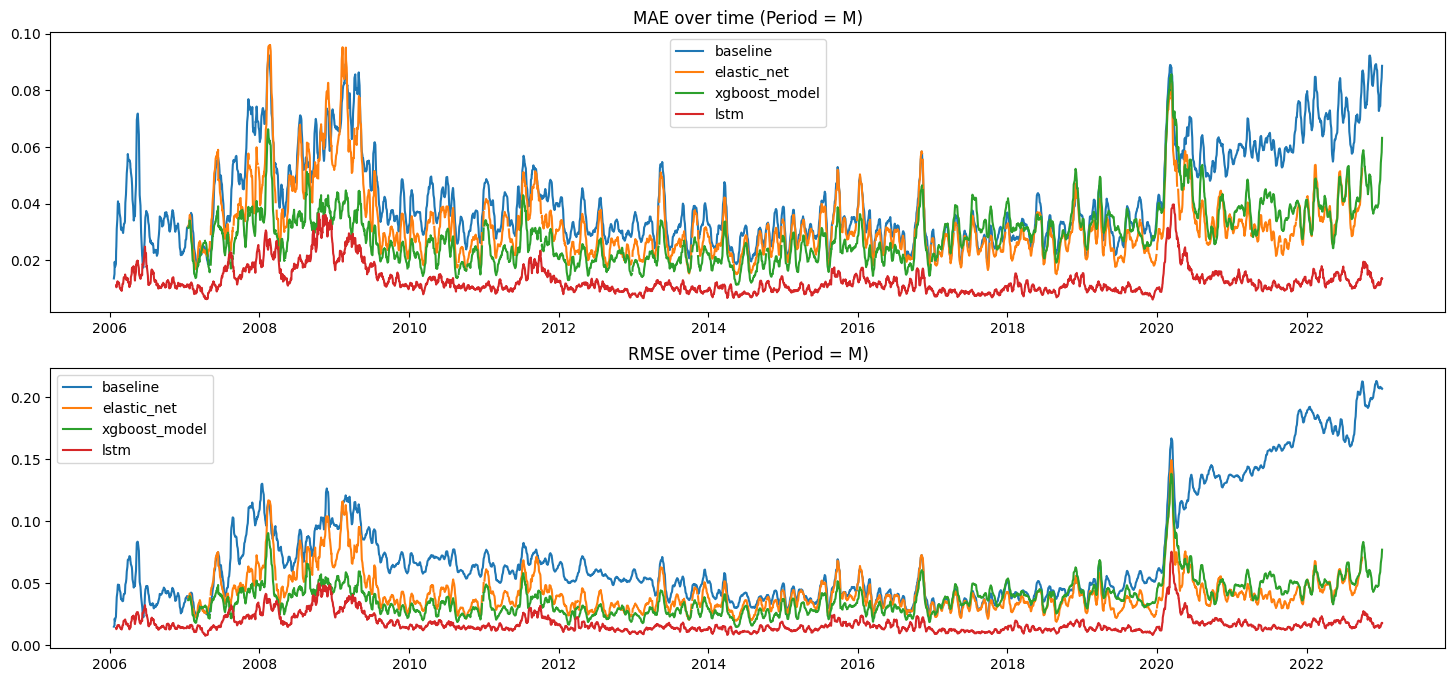

In [51]:
d_table = summarize_accuracy(data_dic, 'D')
w_table = summarize_accuracy(data_dic, 'W')
m_table = summarize_accuracy(data_dic, 'M')

results = pd.concat([d_table, w_table, m_table])

In [52]:
results

train MAE  train RMSE  train R2  test MAE  test RMSE  \
Period Model                                                                 
D      baseline          0.0081      0.0113    0.0124    0.0081     0.0113   
       elastic_net       0.0087      0.0120    0.0007    0.0079     0.0113   
       lstm              0.0088      0.0122    0.0980    0.0080     0.0114   
       xgboost_model     0.0083      0.0113    0.1060    0.0081     0.0114   
W      baseline          0.0180      0.0240   -0.1179    0.0198     0.0265   
       elastic_net       0.0168      0.0224    0.0034    0.0162     0.0222   
       lstm              0.0104      0.0140    0.6477    0.0101     0.0141   
       xgboost_model     0.0156      0.0205    0.1349    0.0172     0.0233   
M      baseline          0.0385      0.0491   -0.6184    0.0476     0.0610   
       elastic_net       0.0316      0.0409    0.0048    0.0314     0.0412   
       lstm              0.0130      0.0177    0.8248    0.0120     0.0166   
       xgboost_model     0.0239      0.0303    0.4218    0.0365     0.0471   

                      test R2  
Period Model                   
D      baseline       -0.1981  
       elastic_net    -0.0003  
       lstm           -0.0060  
       xgboost_model  -0.0242  
W      baseline       -0.7347  
       elastic_net    -0.0004  
       lstm            0.5954  
       xgboost_model  -0.0736  
M      baseline       -3.2610  
       elastic_net    -0.0217  
       lstm            0.8386  
       xgboost_model  -0.3244

In [53]:
from sklearn.metrics import r2_score

In [54]:
df = data_dic['baseline']['M'].copy()
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [c[0] for c in df.columns]
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'],format="%Y-%m-%d")
train_df = df[df.Date<'2017-01-01']
test_df = df[df.Date>='2017-01-01']

train_df = train_df.merge(train_df.groupby('pair')['actual_spread'].mean(), how='left', left_on='pair', right_index=True)
train_df = train_df.rename(columns={'actual_spread_x':'actual_spread', 'actual_spread_y':'actual_spread_mean'})
train_df['pred_m_mean'] = np.square(train_df['pred_spread'] - train_df['actual_spread_mean'])

In [55]:
r2_list = []
for p in test_df['pair'].unique():
    r2 = r2_score(test_df[test_df['pair']==p]['actual_spread'], test_df[test_df['pair']==p]['pred_spread'])
    r2_list.append(r2)

In [56]:
np.mean(r2_list)

-3.260975919842255

In [57]:
r2_list

[0.07939687413803209,
 -1.0317175178212552,
 -1.510268401833724,
 -0.0008281464128723215,
 -0.0063237343167454885,
 -0.0035310625048210476,
 -0.005406169290672169,
 -0.006179333693048683,
 0.011770495435961759,
 -0.0029830598565583344,
 -0.013697958058379145,
 -0.009633715344764093,
 0.004181712180959529,
 0.004614269944100746,
 0.0044957709945624424,
 0.00012683790466416767,
 -0.04563723379923612,
 -0.004798826730114669,
 -0.04142182135141459,
 -0.02573801610712545,
 -6.801802615002178,
 -1.4688272803114168,
 -0.09435052521087295,
 -0.07281726745466477,
 -0.030923074098244907,
 -0.07835562624796322,
 -0.03718173899196353,
 -0.003525717128810335,
 -0.0038679923086304413,
 -0.00028440029377518883,
 -0.0005629733848717677,
 -0.008552426132595992,
 -0.04348838231638741,
 -0.04330776549417825,
 -0.0171029639499527,
 -0.02425796831700877,
 -0.007134962802724409,
 -12.001174251176414,
 -12.219558799288567,
 -0.0313972799660327,
 -0.01007840534861093,
 -0.035883387420783563,
 -0.0211284049653